# Neutron Emitting Spot Size - simulation of the experiment to calibrate the experiment

- MCNP results are in /Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/02.Experiment/lookup_table_simulation/df_MCNP_results_

- very important: As shown in the /Users/hkromer/02_PhD/04_Publiations/04_Reports/06_NeutronEmittingSpotSize/2018-08-14_IonOpticsCurrentTarget.pptx, the definition of the gaussian profile in MCNP6 already has the FWHM, so the "radius" in the dataframe is the FWHM, and NOT the diameter (that would be 2 times the FWHM).

**Further down below is the plot of the lookup table**

## Plots to illustrate the calibration principle

This is all done for the final experimental settings. See http://localhost:8888/lab/tree/02_PhD/01.github/phd/04_emitting_spot_size/02.Experiment.ipynb for the details

1. Compute the total number of counts, assuming 9 hours of total measurement time
2. Plot some ESFs
3. Plot some FWHMs (gaussian curves)

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import os, sys, glob
import re
from scipy.interpolate import interp1d
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy
from scipy import stats
from scipy.stats import poisson
from scipy import optimize
from scipy.misc import derivative
import itertools
%matplotlib inline

import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


## Import data for gaussian and radial

In [2]:
gauss_folder = "/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/05.new_chamber/01.Gauss"
# import the two dataframes. They have the same settings, but different sizes in the MCNP source definition (gaussian profile)    
fname = f'{gauss_folder}/df_MCNP_results.csv'
data_gauss = pd.read_csv(fname, index_col=0)

radial_folder = "/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/05.new_chamber/02.Radial"
# import the two dataframes. They have the same settings, but different sizes in the MCNP source definition (gaussian profile)    
fname = f'{radial_folder}/df_MCNP_results.csv'
data_radial = pd.read_csv(fname, index_col=0)

# radius: MCNP6 gaussian source radius in cm
# x_pos: x position of the edge in mm
# nps: number of particles simulated in MCNP6
# diameter: source diameter gaussian in mm
# Cps_cutoff: counts per second in the detector, cutoff corrected

# properties are the same for all the three runs
fname = f'{gauss_folder}/df_properties.csv'
props_gauss = pd.read_csv(fname, index_col=0)

fname = f'{radial_folder}/df_properties.csv'
props_radial = pd.read_csv(fname, index_col=0)

master_folder = '/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/05.new_chamber/'

data_radial.head()

,case,radius,x_pos,run,nps,entering_tracks,population,F4_tot,R_tot,diameter,f,Cps,Cps_cutoff
0,0,0.005,-2.00,rad0.00500_x-0.20000,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084
1,0,0.005,-1.95,rad0.00500_x-0.19500,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084
2,0,0.005,-1.90,rad0.00500_x-0.19000,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084
3,0,0.005,-1.85,rad0.00500_x-0.18500,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084
4,0,0.005,-1.80,rad0.00500_x-0.18000,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084


### 1. Compute the total number of counts, assuming 9 hours of total measurement time

- this is not so relevant, it just scales the Y axis

In [3]:
meas_time = 9*60*60 # measurement time in seconds
# data.groupby(['diameter']).apply(lambda x: print(x.shape, x.diameter.unique()))
# number of positions for each measurment, check with the above line if it is the same
num_pos_all = data_gauss.groupby(['diameter']).apply(lambda x: x.shape)
num_pos = num_pos_all.values[0][0]
for jj in num_pos_all.values:
    assert num_pos == jj[0]

time_per_pos = meas_time/num_pos # seconds

data_gauss['counts'] = data_gauss['Cps_cutoff'] * time_per_pos
data_gauss.head()

,case,radius,x_pos,run,nps,entering_tracks,population,F4_tot,R_tot,diameter,f,Cps,Cps_cutoff,counts
0,0,0.01,-2.00,rad0.01000_x-0.20000,100000.0,26743,26741,0.950239,0.060941,0.2,0.008481,15504.657948,11628.493461,2.634708e+06
1,0,0.01,-1.95,rad0.01000_x-0.19500,100000.0,26743,26741,0.950239,0.060941,0.2,0.008481,15504.657948,11628.493461,2.634708e+06
2,0,0.01,-1.90,rad0.01000_x-0.19000,100000.0,26743,26741,0.950239,0.060941,0.2,0.008481,15504.657948,11628.493461,2.634708e+06
3,0,0.01,-1.85,rad0.01000_x-0.18500,100000.0,26743,26741,0.950239,0.060941,0.2,0.008481,15504.657948,11628.493461,2.634708e+06
4,0,0.01,-1.80,rad0.01000_x-0.18000,100000.0,26743,26741,0.950239,0.060941,0.2,0.008481,15504.657948,11628.493461,2.634708e+06


In [4]:
meas_time = 9*60*60 # measurement time in seconds
# data.groupby(['diameter']).apply(lambda x: print(x.shape, x.diameter.unique()))
# number of positions for each measurment, check with the above line if it is the same
num_pos_all = data_radial.groupby(['diameter']).apply(lambda x: x.shape)
num_pos = num_pos_all.values[0][0]
for jj in num_pos_all.values:
    assert num_pos == jj[0]

time_per_pos = meas_time/num_pos # seconds

data_radial['counts'] = data_radial['Cps_cutoff'] * time_per_pos
data_radial.head()

,case,radius,x_pos,run,nps,entering_tracks,population,F4_tot,R_tot,diameter,f,Cps,Cps_cutoff,counts
0,0,0.005,-2.00,rad0.00500_x-0.20000,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084,2.638312e+06
1,0,0.005,-1.95,rad0.00500_x-0.19500,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084,2.638312e+06
2,0,0.005,-1.90,rad0.00500_x-0.19000,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084,2.638312e+06
3,0,0.005,-1.85,rad0.00500_x-0.18500,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084,2.638312e+06
4,0,0.005,-1.80,rad0.00500_x-0.18000,100000.0,26784,26784,0.950148,0.061025,0.1,0.008481,15525.867787,11644.40084,2.638312e+06


### 2. Plot some ESFs

The ESF is fitted using:
- use of a logistic fermi function as fit to the ESF: <br>
Li, T. et al. Comparison of different analytical edge spread function models for MTF
calculation using curve-fitting. 74981H (2009). doi:10.1117/12.832793
$$f(x,a,b,c) = \frac{a}{1+\text{exp}\left[-\frac{x-b}{c}\right]}$$
$$\text{FWHM} = 3.53 \cdot c$$


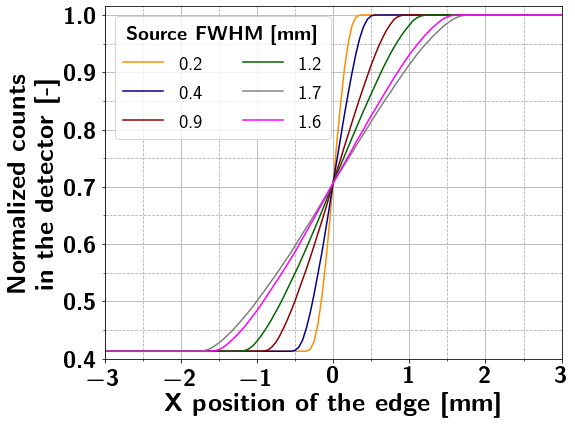

In [5]:
diameters = data_radial['diameter'].unique()
ids = [4,8,16,22,33,30]
colors = ['darkorange', 'darkblue', 'darkred', 'darkgreen', 'gray', 'magenta', 'teal', 'black']
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
fs = 26
markersize = 10
# outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/emitting_spot_size_lookup_table/'
# figname = 'explain_code_esf'

for idx, color in zip(ids, colors):
    diameter = diameters[idx]

    # select only that diameter
    df = data_radial[ data_radial['diameter'] == diameter ]
    df = df.sort_values(by='x_pos')
    
    # normalize the countrate by the lower end ones
    higher_countrates = df[ df['x_pos'] > 5 ]
    mean_higher_countrates = np.mean(higher_countrates['counts'])
    df['counts_normalized'] = df['counts'] / mean_higher_countrates
#     print(mean_lower_countrates)
    # plot
    X = df['x_pos'].values
    y = df['counts_normalized'].values
    plt.plot(X,y, color=color, label=f'{diameter/2:.1f}')

plt.xlabel(r'\textbf{X position of the edge [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Normalized counts}' + '\n'+ r'\textbf{in the detector [-]}', fontsize=fs)


# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')

leg = plt.legend(fontsize=fs-6, loc='best', ncol=2)
leg.set_title(r'\textbf{Source FWHM [mm]}', prop = {'size': fs-6,})
plt.tight_layout()

plt.xlim(-3,3)
plt.ylim(0.4,1.015)
# plt.savefig(f'{outputfolder}/{figname}.pdf')
plt.show()

### 3. Plot some FWHMs

The gaussian function is computing using the FWHM and

$$f(x,\sigma,\mu) = \frac{1}{\sigma \cdot \sqrt{2\cdot \pi}} \text{exp}\left[-\frac{\left(x-\mu\right)^2}{2\cdot \sigma^2}\right]$$

and setting $\mu=0$, calculating $\sigma$ from $\sigma = \frac{\text{FWHM}}{\sqrt{8\cdot \text{ln}\left[2\right]}}$. Where FWHM is computed from the ESF formula.

In [6]:
def fun_calculate_FWHM_of_ESF(
    # calculate the FWHM of the LSF fitted to the ESF
    # return FWHM, Y_log_fermi_func, p1, r_squared
    X,  # X values from the ESF (in mm) 
    Y,  # Y values from the ESF (can be anything)
    p0 # initial guess for the fit
    ):

    # log_fermi_func_zboray
    def fitfunc(p, x):
        z = np.exp( -( (x-p[1])/(p[2]) ) )
        return (p[0] / ( 1 + z )) + p[3]
    def errfunc(p, x, y):
        return fitfunc(p, x) - y # Distance to the fit function


    # m = np.mean(Y[0:5])
    # p0 = [5e+03, 5e-2, radius, m] # Initial guess for the parameters
    p1, success = optimize.leastsq(errfunc, p0[:], args=(X, Y))

    # r-squared
    residuals = Y - fitfunc(p1, X)
    ss_residuals = np.sum(residuals**2)   # residual sum of squares
    ss_tot =  np.sum((Y-np.mean(Y))**2) # total sum of squares
    r_squared = 1 - (ss_residuals / ss_tot)
    FWHM = 3.53 * p1[2]

    Y_log_fermi_func = fitfunc(p1, X)

    # return the FWHM from the 3.53c (logistic fit) and 
    # Y_log_fermi_func: is the Y values for the plot of the log fermi function

    return FWHM, Y_log_fermi_func, p1, r_squared

def gauss_func(x,sigma,mu):
    return ((1/(sigma*np.sqrt(2*np.pi))*np.exp(-((x-mu)**2/(2*(sigma)**2)))))


# Plot of the lookup table

In [9]:
# Add Gen. II
fname = '/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/02.Experiment/lookup_table_simulation/data_old_LUT.csv'
data_GenI_gauss = pd.read_csv(fname)
data_GenI_radial = pd.read_csv('/Users/hkromer/02_PhD/02_Data/09.NeutronEmittingSpot/03.top_hat/LOOKUP_TABLE_TOPHAT.csv')
data_GenI_radial = data_GenI_radial.loc[data_GenI_radial['fwhm'] <= 3.5]
data_GenI_gauss.head()

,diameter,fwhm,fwhm_source
0,0.1,0.037788,0.05
1,0.2,0.087379,0.10
2,0.3,0.132184,0.15
3,0.4,0.176623,0.20
4,0.5,0.219882,0.25


In [12]:
data_GenI_radial.head()

,tophat_diameter,fwhm
0,0.2,0.165891
1,0.7,0.412775
2,1.2,0.695014
3,1.7,0.985494
4,2.2,1.283761


In [13]:
# check the source from the measurement

x_gauss = data_GenI_gauss['fwhm'].values
y_gauss = data_GenI_gauss['fwhm_source'].values
interp_gauss = interp1d(x_gauss, y_gauss)

x_radial = data_GenI_radial['fwhm'].values
y_radial = data_GenI_radial['tophat_diameter'].values
interp_radial = interp1d(x_radial, y_radial)

# from attenuating edge measurement
edge = 1.5
std = 0.2

# value, errors+ and -
gauss_size = [interp_gauss(edge), interp_gauss(edge+std)-interp_gauss(edge), interp_gauss(edge-std)-interp_gauss(edge)]

# value, errors+ and -
radial_size = [interp_radial(edge), interp_radial(edge+std)-interp_radial(edge), interp_radial(edge-std)-interp_radial(edge)]


<ipython-input-6-f74ef40f7c15>:11: RuntimeWarning: overflow encountered in exp
  z = np.exp( -( (x-p[1])/(p[2]) ) )


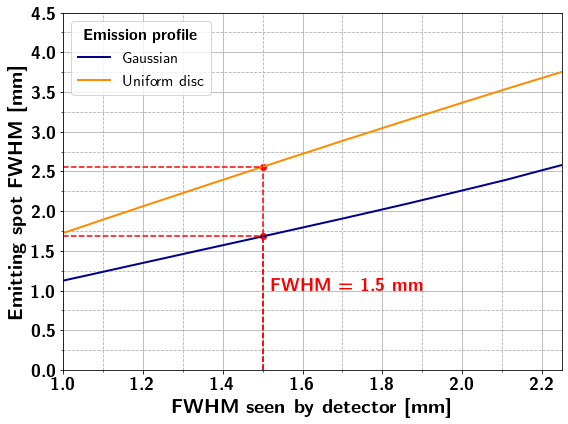

In [15]:
def calculate_fwhm(df):
    df = df.sort_values(by='x_pos')
    
    X = df['x_pos'].values
    y = df['counts'].values
    FWHM = 100
    p0 = [1, 1e-3, 1e-1, 1e3]
    
    while FWHM > 10:
        FWHM, Y_log_fermi_func, p1, r_squared = fun_calculate_FWHM_of_ESF(X,y,p0)
        FWHM = np.abs(FWHM)
        p0[3] = p0[3]+1e3

    return FWHM


fwhms = pd.DataFrame({'fwhm': data_gauss.groupby('diameter').apply(lambda x: calculate_fwhm(x))})
fwhms = fwhms.reset_index()
fwhms['fwhm_source'] = fwhms['diameter']/2 # definition in MCNP is already the FWHM

fwhms_radial = pd.DataFrame({'fwhm': data_radial.groupby('diameter').apply(lambda x: calculate_fwhm(x))})
fwhms_radial = fwhms_radial.reset_index()
fwhms_radial['fwhm_source'] = fwhms_radial['diameter'] # definition in MCNP is already the FWHM

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
fs = 20
markersize = 3

outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/lookup_table/'
figname = 'lookup_table'

# GEN I
# plt.plot(data_GenI_gauss['fwhm'].values, data_GenI_gauss['fwhm_source'].values, '--', color='darkred', linewidth=2)
# plt.plot(data_GenI_radial['fwhm'].values, data_GenI_radial['tophat_diameter'].values, '--',color='darkorange', linewidth=2, alpha=0.4)

# GEN II
plt.plot(fwhms['fwhm'].values, fwhms['fwhm_source'].values, color='darkblue', linewidth=2, label='Gaussian')
plt.plot(fwhms_radial['fwhm'].values, fwhms_radial['fwhm_source'].values, color='darkorange', linewidth=2, label='Uniform disc')
# plt.plot(data_tophat['tophat_diameter'].values, data_tophat['fwhm'].values, color='darkorange', linewidth=2, label='Uniform disc')
# plt.plot(data_tophat['fwhm'].values, data_tophat['tophat_diameter'].values, color='darkorange', linewidth=2, label='Uniform disc')
from matplotlib.lines import Line2D

# vertical lines
plt.plot([edge, edge], [0, interp_gauss(edge)],'--',  color='red')
plt.scatter([edge], [interp_gauss(edge)],  color='red')
plt.scatter([edge], [interp_radial(edge)],  color='red')
plt.plot([1, edge], [interp_gauss(edge), interp_gauss(edge)],'--', color='red')
plt.plot( [1, edge], [interp_radial(edge), interp_radial(edge)],'--', color='red')
plt.plot([edge, edge], [0, interp_radial(edge)], '--', color='red')
plt.text(1.52, 1.0, r'\textbf{FWHM = 1.5 mm}', fontsize=18, color='red')

legend_elements = [Line2D([0], [0], linestyle='--', marker=None, color='black', label='Gen. I neutron generator',
                          markerfacecolor='black', markersize=10, alpha=0.4),
                   Line2D([0], [0], marker=None, color='black', label='Gen. II neutron generator',
                          markerfacecolor='black', markersize=10)
                   ]
l1 = plt.legend(handles=legend_elements,loc='upper right', handlelength=2, fontsize=fs-6)


plt.xlabel(r'\textbf{FWHM seen by detector [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Emitting spot FWHM [mm]}', fontsize=fs)

# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)


ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')


leg = plt.legend(loc='upper left', fontsize=fs-4)
leg.set_title(r"\textbf{Emission profile}", prop = {'size': fs-4})
# plt.gca().add_artist(l1)

# plt.yticks(np.arange(0,6,1))
plt.ylim(0,4.5)
plt.xlim(1.0,2.25)
plt.tight_layout()


# plt.savefig(f'{outputfolder}/{figname}.pdf')
plt.show()